In [8]:
### Comparison of trends in GMST with different priors

In [1]:
### Prior on energy embalance 
### From Sherwood et al. (2025) https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2024AV001636
### We estimate the mean energy imbalance in the period 1970-2024, in 2023 it was reached 1.8 W/m² and the trend is estimated at 0.45 W/m² per decade
def ebm_trend(F=0.8, C=7e8):
    """
    Estimate GMST trend (°C/year) from forcing time series F(t)
    
    F: array-like, radiative forcing in W/m²
    C: heat capacity in J/m²/°C (default 7e8)
    """
    dT_dt = F / C  # °C/s
    return dT_dt * 3.154e7  # °C/year

ebm_trend()

0.036045714285714285

In [10]:
### Imports
import pandas as pd
import xarray as xr
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log, sqrt, pi, exp
from scipy.integrate import quad

In [3]:
### Data
path = "/home/jmindlin/BF_codes/data/DCENT_GMST_statistics.txt"

# Find the header line ("Year,GMST (°C),...")
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

start = next(i for i, line in enumerate(lines) if line.strip().startswith("Year,"))


# Read CSV from that header line onward; allow commas with spaces
df = pd.read_csv(
    path,
    skiprows=start,               # start at the header line
    engine="python",
    sep=r"\s*,\s*",               # split on commas, ignoring surrounding spaces
    comment=None
)

# Clean column names to something easy to use
rename_map = {
    "Year": "year",
    "GMST (°C)": "gmst",
    "1 s.d. (°C)": "gmst_sd",
    "GMST non infilled (°C)": "gmst_noninf",
    "1 s.d. (°C; non  infilled)": "gmst_noninf_sd",
}
# in case of double spaces etc., normalize header keys first
df.columns = [re.sub(r"\s+", " ", c).strip() for c in df.columns]
rename_map_norm = {re.sub(r"\s+", " ", k).strip(): v for k, v in rename_map.items()}
df = df.rename(columns=rename_map_norm)

# Ensure numeric dtypes
for c in ["year", "gmst", "gmst_sd", "gmst_noninf", "gmst_noninf_sd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Convert to xarray
ds = xr.Dataset(
    {
        "GMST": (["year"], df["gmst"].values),
        "GMST_sd": (["year"], df["gmst_sd"].values),
        "GMST_non_infilled": (["year"], df["gmst_noninf"].values),
        "GMST_non_infilled_sd": (["year"], df["gmst_noninf_sd"].values),
    },
    coords={"year": df["year"].values.astype(int)},
)
ds_full = ds.copy()
ds = ds - ds.sel(year=slice('1951','1980')).mean(dim='year')


In [12]:


# ---- Inputs you provide ----
# x: (n,) GMST anomalies
# T: (n,) regressor (e.g., years or centered years)
# beta0: known intercept (float)
# sigma2: known error variance (float)
x = ds['GMST'].sel(year=slice(1979, 2024)).values - np.mean(ds['GMST'].sel(year=slice(1979, 2024)).values)
T = ds.sel(year=slice(1979, 2024)).year.values - np.mean(ds.sel(year=slice(1979, 2024)).year.values)
beta0 = 0.0
sigma2 = np.var(x - np.mean(x))  # estimate from data

# Uniform prior bounds:
a, b = 0.0, 0.05
# Gaussian prior hyperparameters (untruncated closed form)
mu, tau2 = 0.008, (0.004**2)  # example

# ---- Sufficient statistics ----
r = x - beta0                    # (n,)
Sxx = np.sum(T**2)
Sxy = np.sum(T * r)
Syy = np.sum(r**2)
n = len(x)

# ---- SSE(beta) in quadratic form ----
# SSE(beta) = Syy - 2*beta*Sxy + beta^2*Sxx

def loglik(beta):
    sse = Syy - 2.0*beta*Sxy + beta*beta*Sxx
    return -(n/2.0)*log(2*pi*sigma2) - 0.5*sse/sigma2

# H0: beta=0
log_marg_H0 = loglik(0.0)

# ---- (A) Gaussian prior (UNTRUNCATED) closed form ----
A = (Sxx / sigma2) + (1.0 / tau2)
B = (Sxy / sigma2) + (mu / tau2)
# log p(x|H1,N) - log p(x|H0)  (the common big factor cancels)
log_BF10_closed = 0.5*log(2*pi/A) + (B*B)/(2.0*A) - (mu*mu)/(2.0*tau2)

# If you also want the absolute log marginal under H1 (not just BF):
# log_marg_H1_closed = log_marg_H0 + log_BF10_closed

# ---- (B) Uniform prior on [a,b] via numeric integration ----
def log_integrand_uniform(beta):
    return loglik(beta) - log(b - a)  # add log prior

# Stable log-integral: log ∫ exp(f) dβ  ≈ logsumexp via quadrature
# We integrate in linear space but shift the exponent for stability.
# A robust way: find mode of loglik (beta_hat = Sxy/Sxx) to use as shift.
beta_hat = Sxy / Sxx if Sxx > 0 else 0.0
c = loglik(beta_hat)  # shift

def integrand_shifted(beta):
    return exp(log_integrand_uniform(beta) - c)

I_uniform, _ = quad(integrand_shifted, a, b, epsabs=1e-10, epsrel=1e-9, limit=200)
log_marg_H1_uniform = c + log(I_uniform)
log_BF10_uniform = log_marg_H1_uniform - log_marg_H0

# ---- (C) Truncated Gaussian prior on [a,b] via numeric integration ----
Z = norm.cdf((b - mu)/sqrt(tau2)) - norm.cdf((a - mu)/sqrt(tau2))

def log_prior_trunc_normal(beta):
    return -0.5*log(2*pi*tau2) - 0.5*((beta - mu)**2)/tau2 - log(Z)

def log_integrand_truncN(beta):
    return loglik(beta) + log_prior_trunc_normal(beta)

c2 = log_integrand_truncN(beta_hat)
def integrand_shifted_truncN(beta):
    return exp(log_integrand_truncN(beta) - c2)

I_truncN, _ = quad(integrand_shifted_truncN, a, b, epsabs=1e-10, epsrel=1e-9, limit=200)
log_marg_H1_truncN = c2 + log(I_truncN)
log_BF10_truncN = log_marg_H1_truncN - log_marg_H0

# ---- Report (in both natural log and log10) ----
def to_log10(z): return z / log(10.0)

print("BF10 (Gaussian prior, closed form):")
print(f"  ln BF10 = {log_BF10_closed:.4f},  log10 BF10 = {to_log10(log_BF10_closed):.4f}")

print("BF10 (Uniform prior [a,b], numeric):")
print(f"  ln BF10 = {log_BF10_uniform:.4f}, log10 BF10 = {to_log10(log_BF10_uniform):.4f}")

print("BF10 (Trunc. Gaussian prior [a,b], numeric):")
print(f"  ln BF10 = {log_BF10_truncN:.4f}, log10 BF10 = {to_log10(log_BF10_truncN):.4f}")


BF10 (Gaussian prior, closed form):
  ln BF10 = 12.1919,  log10 BF10 = 5.2949
BF10 (Uniform prior [a,b], numeric):
  ln BF10 = 17.8621, log10 BF10 = 7.7574
BF10 (Trunc. Gaussian prior [a,b], numeric):
  ln BF10 = 16.8175, log10 BF10 = 7.3037


In [13]:
beta_grid = np.linspace(-0.01, 0.06, 1000)
### Define thr prior_truncN for plotting 
prior_truncN = np.zeros_like(beta_grid)
Z = norm.cdf((b - mu)/np.sqrt(tau2)) - norm.cdf((a - mu)/np.sqrt(tau2))
for i, beta in enumerate(beta_grid):
    if a <= beta <= b:
        prior_truncN[i] = norm.pdf(beta, loc=mu, scale=np.sqrt(tau2)) / Z
    else:
        prior_truncN[i] = 0.0


In [14]:
# === FONT SETTINGS ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 16
TICK_FONTSIZE  = 14
LEGEND_FONTSIZE = 13

# ===========================================
# Example inputs (replace with your GMST data)
# ===========================================
# Prior hyperparameters
a, b = 0.0, 0.05        # Uniform and truncation bounds
mu, tau2 = 0.027, 0.01**2

# ---- Statistics ----
r = x - beta0
Sxx = np.sum(T**2)
Sxy = np.sum(T * r)
Syy = np.sum(r**2)

# ---- Likelihood (log form) ----
def loglik(beta):
    sse = Syy - 2.0 * beta * Sxy + beta * beta * Sxx
    return -(n / 2.0) * log(2 * pi * sigma2) - 0.5 * sse / sigma2

# === H0 ===
log_marg_H0 = loglik(0.0)

# ======================================
# (A) Gaussian prior (untruncated) closed form
# ======================================
A = (Sxx / sigma2) + (1.0 / tau2)
B = (Sxy / sigma2) + (mu / tau2)
log_BF10_closed = 0.5 * log(2 * pi / A) + (B * B) / (2.0 * A) - (mu * mu) / (2.0 * tau2)
log_marg_H1_closed = log_marg_H0 + log_BF10_closed

# ======================================
# (B) Uniform prior [a,b] (numeric integration)
# ======================================
def log_integrand_uniform(beta):
    return loglik(beta) - log(b - a)

beta_hat = Sxy / Sxx if Sxx > 0 else 0.0
c = loglik(beta_hat)

def integrand_shifted(beta):
    return exp(log_integrand_uniform(beta) - c)

I_uniform, _ = quad(integrand_shifted, a, b, epsabs=1e-10, epsrel=1e-9, limit=200)
log_marg_H1_uniform = c + log(I_uniform)
log_BF10_uniform = log_marg_H1_uniform - log_marg_H0

# ======================================
# (C) Truncated Gaussian prior [a,b] (numeric)
# ======================================
Z = norm.cdf((b - mu) / sqrt(tau2)) - norm.cdf((a - mu) / sqrt(tau2))

def log_prior_trunc_normal(beta):
    return -0.5 * log(2 * pi * tau2) - 0.5 * ((beta - mu) ** 2) / tau2 - log(Z)

def log_integrand_truncN(beta):
    return loglik(beta) + log_prior_trunc_normal(beta)

c2 = log_integrand_truncN(beta_hat)
def integrand_shifted_truncN(beta):
    return exp(log_integrand_truncN(beta) - c2)

I_truncN, _ = quad(integrand_shifted_truncN, a, b, epsabs=1e-10, epsrel=1e-9, limit=200)
log_marg_H1_truncN = c2 + log(I_truncN)
log_BF10_truncN = log_marg_H1_truncN - log_marg_H0

# === Print results ===
def to_log10(z): return z / log(10.0)

print("=== Bayes Factors (H1/H0) ===")
print(f"Gaussian prior (closed form): ln BF10 = {log_BF10_closed:.4f}, log10 BF10 = {to_log10(log_BF10_closed):.4f}")
print(f"Uniform prior [a,b]:          ln BF10 = {log_BF10_uniform:.4f}, log10 BF10 = {to_log10(log_BF10_uniform):.4f}")
print(f"Trunc. Gaussian prior [a,b]:  ln BF10 = {log_BF10_truncN:.4f}, log10 BF10 = {to_log10(log_BF10_truncN):.4f}")

# ======================================
# === Likelihood and priors ===
# ======================================
beta_grid = np.linspace(-0.005, 0.05, 300)
likelihoods = np.exp([loglik(b) - np.max([loglik(bg) for bg in beta_grid]) for b in beta_grid])

prior_uniform = np.ones_like(beta_grid) / (b - a)
prior_uniform[(beta_grid < a) | (beta_grid > b)] = 0

prior_gaussian = norm.pdf(beta_grid, mu, sqrt(tau2))
prior_gaussian /= prior_gaussian.max()


=== Bayes Factors (H1/H0) ===
Gaussian prior (closed form): ln BF10 = 14.5376, log10 BF10 = 6.3136
Uniform prior [a,b]:          ln BF10 = 17.8621, log10 BF10 = 7.7574
Trunc. Gaussian prior [a,b]:  ln BF10 = 18.2382, log10 BF10 = 7.9207


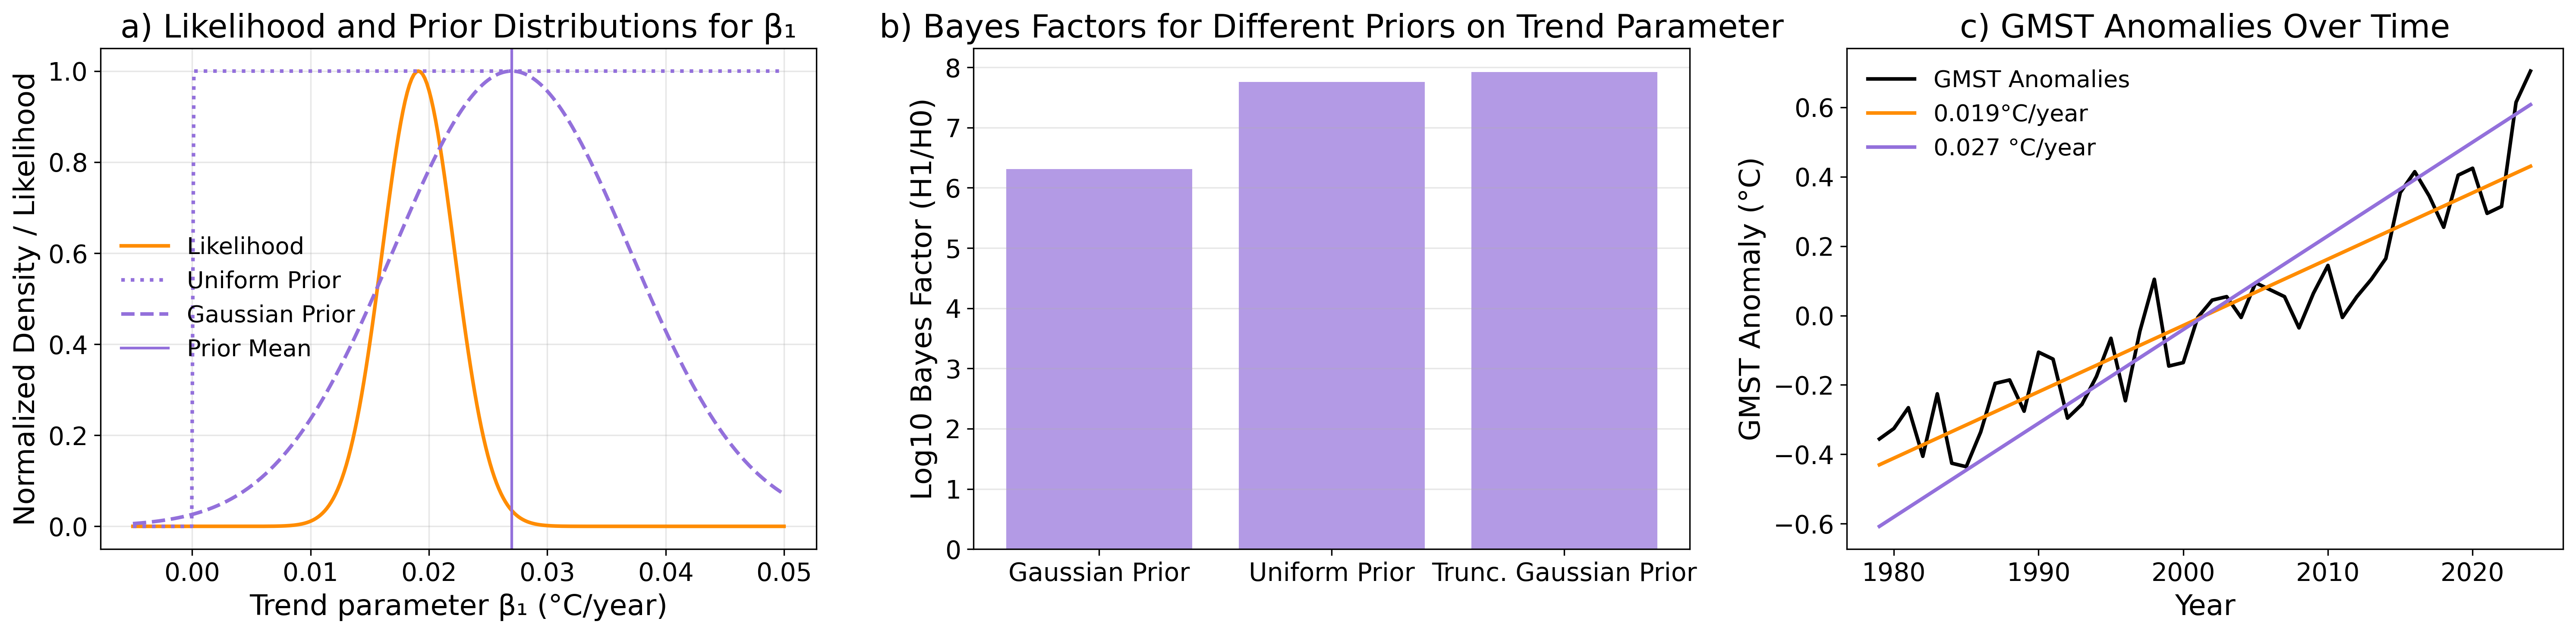

In [21]:
### Join the two figures above in a single figure with two panels
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=300)
# Panel 1: Likelihood and Priors
axs[0].plot(beta_grid, likelihoods / np.max(likelihoods), label="Likelihood", color="DarkOrange", linewidth=2)
axs[0].plot(beta_grid, prior_uniform / np.max(prior_uniform), label="Uniform Prior", color="MediumPurple", linestyle=":", linewidth=2)
axs[0].plot(beta_grid, prior_gaussian, label="Gaussian Prior", color="MediumPurple", linestyle="--", linewidth=2)
axs[0].axvline(mu, color="MediumPurple", linestyle="-", linewidth=1.5, label="Prior Mean")
axs[0].set_xlabel("Trend parameter β₁ (°C/year)", fontsize=LABEL_FONTSIZE)
axs[0].set_ylabel("Normalized Density / Likelihood", fontsize=LABEL_FONTSIZE)
axs[0].set_title("a) Likelihood and Prior Distributions for β₁", fontsize=TITLE_FONTSIZE)
axs[0].tick_params(axis="both", labelsize=TICK_FONTSIZE)
axs[0].legend(fontsize=LEGEND_FONTSIZE, frameon=False)
axs[0].grid(alpha=0.3)
# Panel 2: Bayes Factors
bf_labels = ['Gaussian Prior', 'Uniform Prior', 'Trunc. Gaussian Prior']
bf_values = [to_log10(log_BF10_closed), to_log10(log_BF10_uniform), to_log10(log_BF10_truncN)]
axs[1].bar(bf_labels, bf_values, color='MediumPurple', alpha=0.7)
axs[1].set_ylabel('Log10 Bayes Factor (H1/H0)', fontsize=LABEL_FONTSIZE)
axs[1].set_title('b) Bayes Factors for Different Priors on Trend Parameter', fontsize=TITLE_FONTSIZE)
axs[1].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[1].grid(axis='y', alpha=0.3)
# Panel 3: Time series and trend
axs[2].plot(ds.sel(year=slice(1979, 2024)).year, ds.sel(year=slice(1979, 2024)).GMST-np.mean(ds.sel(year=slice(1979, 2024)).GMST), label="GMST Anomalies", color="k", linewidth=2)
axs[2].set_xlabel("Year", fontsize=LABEL_FONTSIZE)
axs[2].set_ylabel("GMST Anomaly (°C)", fontsize=LABEL_FONTSIZE)
# Linear trend line
trend_line = beta0 + (Sxy / Sxx) * (ds.sel(year=slice(1979, 2024)).year - np.mean(ds.sel(year=slice(1979, 2024)).year.values))
axs[2].plot(ds.sel(year=slice(1979, 2024)).year, trend_line, label=str(round(beta0 + (Sxy / Sxx),3))+'°C/year', color="DarkOrange", linestyle="-", linewidth=2)
trend_line_prior = 0.027 * (ds.sel(year=slice(1979, 2024)).year - np.mean(ds.sel(year=slice(1979, 2024)).year.values))
axs[2].plot(ds.sel(year=slice(1979, 2024)).year, trend_line_prior, label='0.027 °C/year', color="MediumPurple", linestyle="-", linewidth=2)

axs[2].set_title("c) GMST Anomalies Over Time", fontsize=TITLE_FONTSIZE)
axs[2].tick_params(axis="both", labelsize=TICK_FONTSIZE)
axs[2].legend(fontsize=LEGEND_FONTSIZE, frameon=False)
plt.tight_layout()
plt.show()
